# Model-based attacks VS FGSM / iFGSM

## Preprocessing

In [1]:
%pip install tsai

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
SEED = 123
from collections import defaultdict
from collections import Counter
import random, os
import numpy as np


import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, LabelEncoder

import optuna

from typing import Optional
import tsai.models.all as mdls
from tsai.models.all import ResCNN


In [4]:

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### EarlyStopping utility

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, mode='min'):
        assert mode in ('min', 'max')
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            self.counter = 0
            return False
        improvement = (metric < self.best - self.min_delta) if self.mode == 'min' else (metric > self.best + self.min_delta)
        if improvement:
            self.best = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop


### Dataset preparation

In [7]:
TRAIN_PATH = Path('FordA_TRAIN.tsv')
TEST_PATH = Path('FordA_TEST.tsv')
BATCH_SIZE = 64
# EPOCHS = 50
# LR = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
def load_powercon(path: Path):
    df = pd.read_csv(path, sep='\t', header=None)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y).astype(np.int64)
    return X, y_encoded, le.classes_

In [9]:
%ls

FordA_TEST.tsv
FordA_TRAIN.tsv
PowerCons_TEST.tsv
PowerCons_TRAIN.tsv
Untitled.ipynb
attacker_iter_unrolled.pth
datasets@
filestore@
project@
rescnn_classifier_best.pth
s3@
surrogate_maxloss.pth


In [10]:
X_train, y_train, classes_ = load_powercon(TRAIN_PATH)
X_test, y_test, _ = load_powercon(TEST_PATH)
n_classes = len(classes_)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape, 'n_classes:', n_classes)

Train shape: (3601, 500, 1) Test shape: (1320, 500, 1) n_classes: 2


In [11]:
class PowerConDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PowerConDataset(X_train, y_train)
test_ds = PowerConDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [12]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

-4.48746 4.8406954 -4.520504 4.263037


counts:
-1    1846
 1    1755
Name: 0, dtype: int64
shares:
-1    0.512635
 1    0.487365
Name: 0, dtype: float64


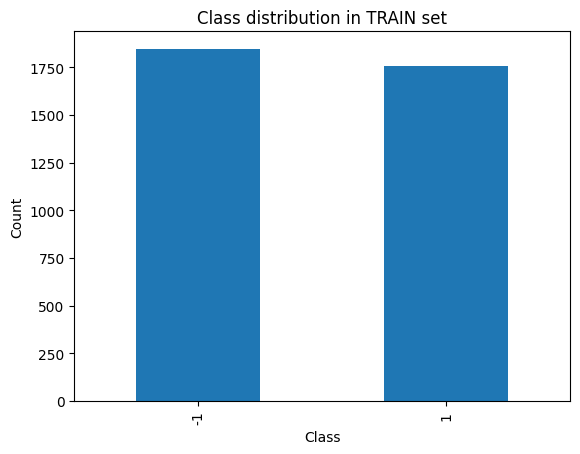

In [13]:
# check data-balance

df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)

# 1. Считаем количество примеров каждого класса
label_counts = df.iloc[:, 0].value_counts().sort_index()
print(f'counts:\n{label_counts}')                # абсолютные значения
print(f'shares:\n{label_counts / len(df)}')      # доли

# 2. Быстрый бар-чарт
label_counts.plot.bar()
plt.title('Class distribution in TRAIN set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [14]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)

## Classifiers

In [15]:
def accuracy(logits, target):
    return (logits.argmax(1) == target).float().mean().item()

In [16]:
class Activation(nn.Module):
    def __init__(self, kind='identity'):
        super().__init__()
        if kind == 'identity':
            self.act = nn.Identity()
        elif kind == 'relu':
            self.act = nn.ReLU()
        elif kind == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError(f'Unknown activation {kind}')
    def forward(self, x):
        return self.act(x)

### LSTM Classifier

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_classes, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, n_classes)
    def forward(self, x):
        out, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])


### LongLSTM Classifier

In [18]:
class LongLSTMClassifier(nn.Module):
    """
    Делит последовательность на N равных частей и прогоняет каждую
    через собственный экземпляр LSTMClassifier. Финальный ответ —
    наиболее встречающаяся метка (mode) среди N предсказаний.

    Parameters
    ----------
    n_classes : int
        Число классов.
    n_splits : int
        Сколько кусков делать из входной последовательности.
    input_size, hidden_size, num_layers, dropout
        Параметры, которые передаются во внутренние LSTMClassifier’ы.
    """
    def __init__(self,
                 n_classes: int,
                 n_splits: int = 5,
                 input_size: int = 1,
                 hidden_size: int = 64,
                 num_layers: int = 2,
                 dropout: float = 0.2):
        super().__init__()
        assert n_splits >= 1, "n_splits должно быть ≥ 1"
        self.n_splits = n_splits

        # создаём N независимых LSTMClassifier’ов
        self.sub_nets = nn.ModuleList([
            LSTMClassifier(n_classes,
                           input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           dropout=dropout)
            for _ in range(n_splits)
        ])

    # def forward(self, x: torch.Tensor) -> torch.Tensor:
    #     """
    #     x : (B, L, C) – батч длинных последовательностей
    #     Возвращает (B,) с итоговой меткой, либо (B, n_classes) с логитами,
    #     если нужно (зависит от задачи).
    #     """
    #     B, L, C = x.shape
    #     # длина одного куска (последний может быть короче)
    #     chunk_len = (L + self.n_splits - 1) // self.n_splits

    #     logits_list = []
    #     for i in range(self.n_splits):
    #         start = i * chunk_len
    #         end   = min(start + chunk_len, L)
    #         if start >= L:                       # если кусок «вышел» за предел – дублируем последний
    #             part = x[:, -chunk_len:, :]
    #         else:
    #             part = x[:, start:end, :]        # (B, chunk, C)
    #         # прогоняем через свой LSTM
    #         logits = self.sub_nets[i](part)      # (B, n_classes)
    #         logits_list.append(logits)

    #     # -> (n_splits, B, n_classes)
    #     stacked = torch.stack(logits_list, dim=0)
    #     # предсказанные метки каждой подсети, shape (n_splits, B)
    #     preds = stacked.argmax(-1)

    #     # мода по оси n_splits
    #     mode_preds = []
    #     for b in range(B):
    #         # Counter возвращает [(метка, частота), ...]; берём самую частую
    #         most_common = Counter(preds[:, b].tolist()).most_common(1)[0][0]
    #         mode_preds.append(most_common)
    #     mode_preds = torch.tensor(mode_preds, device=x.device)  # (B,)

    #     return mode_preds        # можно вернуть ещё stacked.mean(0) как «сглаженные» логиты


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        chunk_len = (L + self.n_splits - 1) // self.n_splits

        logits_per_split = []
        for i in range(self.n_splits):
            start = i * chunk_len
            end   = min(start + chunk_len, L)
            part  = x[:, start:end, :] if start < L else x[:, -chunk_len:, :]
            logits_per_split.append(self.sub_nets[i](part))   # (B, n_classes)

        # (n_splits, B, n_classes) → усредняем / суммируем
        logits = torch.stack(logits_per_split, dim=0).mean(0)   # (B, n_classes)
        return logits

### ResCNN Classifier

In [19]:
class ResCNNClassifier(nn.Module):
    def __init__(self, n_classes, x_dim=1, activation_type='identity', rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}

        # NN-backbone: tsai.models.ResCNN
        self.body = ResCNN(c_in=x_dim, c_out=n_classes, **rescnn_kwargs)
        self.fin = Activation(activation_type)

    def forward(self, x):
        # (B,L,C) or (B,C,L) —> (B,C,L)
        if x.ndim == 3 and x.shape[1] != self.x_dim:   # (B,L,C)
            x = x.transpose(1, 2)
        return self.fin(self.body(x))                  # logits

### Training classifiers

In [20]:
def train_classifier(model,
                     train_loader,
                     val_loader=None,
                     epochs=50,
                     lr=1e-3,
                     weight_decay=0.,
                     device="cpu",
                     patience=5,
                     verbose_every=3):
    """
    returns: dict(history), best_val_loss, best_state_dict
    """
    model.to(device)
    opt      = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    stopper  = EarlyStopping(patience=patience, mode="min") if val_loader else None
    history  = defaultdict(list)
    best_wts = model.state_dict()
    best_val = float("inf")

    for ep in range(1, epochs + 1):
        # ----- train -----
        model.train()
        loss_sum, acc_sum, n = 0., 0., 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss   = F.cross_entropy(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item() * x.size(0)
            acc_sum  += (logits.argmax(1) == y).float().sum().item()
            n += x.size(0)

        train_loss = loss_sum / n
        train_acc  = acc_sum  / n
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ----- validation -----
        if val_loader:
            model.eval()
            with torch.no_grad():
                loss_sum, acc_sum, n = 0., 0., 0
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    loss   = F.cross_entropy(logits, y)
                    loss_sum += loss.item() * x.size(0)
                    acc_sum  += (logits.argmax(1) == y).float().sum().item()
                    n += x.size(0)

            val_loss = loss_sum / n
            val_acc  = acc_sum  / n
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            if val_loss < best_val:
                best_val = val_loss
                best_wts = {k: v.cpu() for k, v in model.state_dict().items()}

            if stopper and stopper.step(val_loss):
                if verbose_every:
                    print(f"⏹ Early stopping on epoch {ep:02d}")
                break

        if verbose_every and ep % verbose_every == 0:
            msg = f"Epoch {ep:02d}: train_loss={train_loss:.4f} acc={train_acc:.4f}"
            if val_loader:
                msg += f" | val_loss={val_loss:.4f} acc={val_acc:.4f}"
            print(msg)

    model.load_state_dict(best_wts)
    return history, best_val, best_wts



#### train clf_LSTM

In [21]:
# clf_LSTM = LSTMClassifier(n_classes, hidden_size=50, num_layers=1)

# history, _, _=  train_classifier(
#     clf_LSTM,
#     train_dl,
#     val_loader=test_dl,
#     epochs=50,
#     lr=1e-3,
#     weight_decay=0.,
#     device=device,
#     patience=4,
#     verbose_every=1
# )

#### train LongLSTM

In [22]:
clf_LSTM = LongLSTMClassifier(
    n_classes=n_classes,
    n_splits=10,
    input_size=1,
    hidden_size=64,
    num_layers=2,
    dropout=0.3
).to(device)

history, _, _=  train_classifier(
    clf_LSTM,
    train_dl,
    val_loader=test_dl,
    epochs=45,
    lr=1e-3,
    weight_decay=0.,
    device=device,
    patience=10,
    verbose_every=1
)

Epoch 01: train_loss=0.6934 acc=0.5026 | val_loss=0.6926 acc=0.5152
Epoch 02: train_loss=0.6932 acc=0.5101 | val_loss=0.6935 acc=0.5008
Epoch 03: train_loss=0.6935 acc=0.4957 | val_loss=0.6924 acc=0.5189
Epoch 04: train_loss=0.6928 acc=0.5162 | val_loss=0.6924 acc=0.5144
Epoch 05: train_loss=0.6929 acc=0.5065 | val_loss=0.6923 acc=0.5053
Epoch 06: train_loss=0.6923 acc=0.5096 | val_loss=0.6926 acc=0.5091
Epoch 07: train_loss=0.6921 acc=0.5135 | val_loss=0.6923 acc=0.5114
Epoch 08: train_loss=0.6925 acc=0.4938 | val_loss=0.6926 acc=0.5189
Epoch 09: train_loss=0.6917 acc=0.5146 | val_loss=0.6926 acc=0.5159
Epoch 10: train_loss=0.6915 acc=0.5146 | val_loss=0.6930 acc=0.5091
Epoch 11: train_loss=0.6901 acc=0.5221 | val_loss=0.6916 acc=0.5265
Epoch 12: train_loss=0.6816 acc=0.5682 | val_loss=0.6856 acc=0.5235
Epoch 13: train_loss=0.6515 acc=0.6048 | val_loss=0.6456 acc=0.5977
Epoch 14: train_loss=0.6255 acc=0.6454 | val_loss=0.6514 acc=0.6386
Epoch 15: train_loss=0.6063 acc=0.6559 | val_los

#### train clf_resCNN

In [23]:
clf_resCNN = ResCNNClassifier(n_classes=n_classes, x_dim=1).to(device)

history, best_val, best_state = train_classifier(
    clf_resCNN,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=8,
    lr=1e-4,
    weight_decay=1e-4,
    device=device,
    patience=10,
    verbose_every=1
)

torch.save(best_state, "rescnn_classifier_best.pth")

Epoch 01: train_loss=0.5210 acc=0.7442 | val_loss=0.4121 acc=0.7750
Epoch 02: train_loss=0.3632 acc=0.8567 | val_loss=0.3331 acc=0.8545
Epoch 03: train_loss=0.3042 acc=0.8889 | val_loss=0.2989 acc=0.8871
Epoch 04: train_loss=0.2808 acc=0.8970 | val_loss=0.3322 acc=0.8485
Epoch 05: train_loss=0.2706 acc=0.8945 | val_loss=0.2495 acc=0.8924
Epoch 06: train_loss=0.2554 acc=0.9006 | val_loss=0.2671 acc=0.8909
Epoch 07: train_loss=0.2489 acc=0.8995 | val_loss=0.2903 acc=0.8667
Epoch 08: train_loss=0.2386 acc=0.9025 | val_loss=0.3061 acc=0.8667


#### optuna for LSTM clf

In [24]:
def objective(trial):
    # --- hyperparams ---
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    clf_model = LSTMClassifier(n_classes,
                               hidden_size=hidden_dim,
                               dropout=dropout)

    history, _, _=  train_classifier(clf_model,
                     train_dl,
                     val_loader=test_dl,
                     epochs=50,
                     lr=lr,
                     weight_decay=0.,
                     device=device,
                     patience=patience,
                     verbose_every=1)

    return history['val_acc'][-1]

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST_PARAMS:", study.best_params)


## Adversarial Attacks

In [85]:
class Attack:
    def __init__(self, eps: float, clamp=(-1, 1)):
        self.eps = eps
        self.clamp = clamp

# class ModelBasedAttack(Attack):
#     def __init__(self, surrogate, eps, clamp=(-1, 1)):
#         super().__init__(eps, clamp)
#         self.surr = surrogate.eval()

#     @torch.no_grad()
#     def __call__(self, model, x, y):
#         delta = self.eps * torch.tanh(self.surr(x))
#         return torch.clamp(x + delta, *self.clamp)

class ModelBasedAttack(Attack):
    def __init__(self, attacker, eps, clamp=None, is_iter=False):
        super().__init__(eps, clamp)
        self.attacker = attacker.eval()
        self.is_iter = is_iter

    @torch.no_grad()
    def __call__(self, model, x, y):
        if not self.is_iter:
            # delta = self.eps * self.attacker(x).sign()
            delta = self.eps * torch.tanh(self.attacker(x))
            # print(f"L2 norm = {torch.norm(delta, p=2)}, L_infty norm = {torch.norm(delta, p=float('inf'))}")
            x_adv = x + delta
            if not self.clamp is None:
                x_adv = torch.clamp(x_adv, *self.clamp)
            return x_adv
        else:
            return self.attacker(x)




# class Attack:
#     def __init__(self, eps: float, clamp=(-1, 1)):
#         self.eps = eps
#         self.clamp = clamp

# import torch

# class ModelBasedAttack(Attack):
#     def __init__(self, attacker, eps, n_iter=10, alpha=None, clamp=None,
#                  rand_init=False, equal_eps=False):
#         """
#         attacker: nn.Module, генерирует карту возмущения той же формы, что x
#         eps:     радиус L∞-шара
#         n_iter:  число итераций
#         alpha:   шаг; по умолчанию 1.5*eps/n_iter (как у iFGSM)
#         clamp:   (min, max) или None — диапазон данных
#         rand_init: старт из случайной точки в L∞-шаре
#         equal_eps: пытаться держать ||delta||_inf == eps (где возможно)
#         """
#         super().__init__(eps, clamp)
#         self.attacker = attacker.eval()
#         for p in self.attacker.parameters():
#             p.requires_grad_(False)
#         self.n_iter = n_iter
#         # self.alpha  = alpha or (1.5 * eps / n_iter)
#         self.alpha = eps
#         self.rand_init = rand_init
#         self.equal_eps = equal_eps

#     @staticmethod
#     @torch.no_grad()
#     def _rand_init_linf(x, eps, clamp, equal_eps: bool):
#         delta = torch.empty_like(x).uniform_(-eps, eps)
#         if equal_eps:
#             flat = delta.abs().flatten(1)
#             amax = flat.amax(dim=1)
#             scale = (eps / (amax + 1e-12)).view(-1, *[1]*(delta.dim()-1))
#             delta = (delta * scale).clamp(-eps, eps)
#         x0 = x + delta
#         if clamp is not None:
#             x0 = torch.clamp(x0, *clamp)
#         return x0

#     @torch.no_grad()
#     def __call__(self, model, x, y):
#         x = x.detach()
#         if self.rand_init:
#             x_adv = self._rand_init_linf(x, self.eps, self.clamp, self.equal_eps)
#         else:
#             x_adv = x.clone()

#         for _ in range(self.n_iter):
#             step = self.alpha * torch.tanh(self.attacker(x_adv))
#             x_adv = x_adv + step
#             if self.clamp is not None:
#                 x_adv = torch.clamp(x_adv, *self.clamp)

#         return x_adv.detach()


### train_atk_model

In [64]:
def train_atk_model(atk_model,
                    victim,
                    loader,
                    eps=0.5,
                    epochs=50,
                    lr=1e-4,
                    alpha_l2=1e-3,
                    device='cpu',
                    patience=4,
                    is_clamped=False,
                    is_debugged=False
                    ):
    atk_model.to(device)
    # victim.to(device).eval()
    victim.train()
    for param in victim.parameters():
      param.requires_grad_(False)

    opt = torch.optim.Adam(atk_model.parameters(), lr)
    stopper = EarlyStopping(patience=patience, mode="max")
    for ep in range(1, epochs+1):
        atk_model.train()
        run_vloss, run_acc, n = 0., 0., 0


        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # atk_model.eval()
            #* tanh regularization
            # delta = eps * torch.tanh(atk_model(x))

            #* l2-proj regularization
            raw_delta = atk_model(x)
            norms = raw_delta.norm(p=2, dim=(1, 2), keepdim=True)  # (B, 1, 1)
            delta  = eps * raw_delta / (norms + 1e-12)

            #* sign regularization
            # delta = eps * torch.sign(atk_model(x))

            # atk_model.train()

            if is_clamped:
                delta = torch.clamp(delta, -1, 1)

            x_adv = x + delta
            logits = victim(x_adv)

            vloss = F.cross_entropy(logits, y)
            acc = (logits.argmax(1) == y).float().mean().item()
            reg = alpha_l2 * (delta**2).mean()
            loss = -(vloss - reg)
            if is_debugged:
                print(f'\nx={((x[0].detach().cpu()**2).mean())**0.5}')
                print(f'delta={(delta[0].detach().cpu().norm(p=2).item())}')
                print(f'y={y.detach().cpu()[0]}|logits={logits.detach().cpu().argmax(1)[0]}')
                print(f'vloss = {vloss}| reg = {reg}')

                with torch.no_grad():
                    # ----- (2) % L2-нормы входа -----
                    # L2 посчитаем по каждому объекту, затем усредним
                    l2_delta = torch.norm(delta.view(delta.size(0), -1), p=2, dim=1)
                    l2_x_adv = torch.norm(x_adv.view(x_adv.size(0), -1), p=2, dim=1) + 1e-8
                    l2_x     = torch.norm(x.view(x.size(0), -1),     p=2, dim=1) + 1e-8
                    perc_l2_x_adv  = (l2_delta / l2_x_adv * 100).mean().item()
                    perc_l2_x  = (l2_x_adv / l2_x * 100).mean().item()

                print(f'\nL2:Δ/x_adv: {perc_l2_x_adv:6.2f}%   x_adv/x: {perc_l2_x:6.2f}%')

            opt.zero_grad()
            loss.backward()
            opt.step()
            run_vloss += vloss.item()*x.size(0)
            run_acc += acc * x.size(0)
            n += x.size(0)

        val_loss = run_vloss / n
        print(f'\nEpoch {ep:02d} | victim‑loss {val_loss:.4f} | acc {run_acc/n:.4f}')
        if stopper.step(val_loss):
            print(f'⏹ Early stopping at epoch {ep}')
            break
    torch.save(atk_model.state_dict(), 'surrogate_maxloss.pth')
    return val_loss, run_acc/n


### LSTM && LongLSTM Attack

In [65]:
class attack_LSTM(nn.Module):
    def __init__(self, hidden_dim=64, x_dim=1, activation_type='identity', dropout=0.25):
        super().__init__()
        self.rnn_inp = nn.LSTM(x_dim, hidden_dim, num_layers=3, batch_first=True, dropout=dropout)
        self.act = Activation(activation_type)
        # ! delete fc
        self.rnn_out = nn.LSTM(hidden_dim, x_dim, num_layers=3, batch_first=True, dropout=dropout)
        # self.fc = nn.Linear(hidden_dim, x_dim)
    def forward(self, data):
        x, _ = self.rnn_inp(data)
        x = self.act(x)
        x, _ = self.rnn_out(x)
        return x


In [66]:
class AttackLongLSTM(nn.Module):
    """
    Разбивает вход (B, L, C) на n_splits кусков по временной оси,
    каждый кусок ― своя attack_LSTM. На выходе тензор той же формы.
    """
    def __init__(
        self,
        n_splits: int = 4,
        hidden_dim: int = 64,
        x_dim: int = 1,
        activation_type: str = "identity",
        dropout: float = 0.25,
    ):
        super().__init__()
        assert n_splits >= 1, "n_splits должно быть ≥ 1"
        self.n_splits = n_splits

        # N независимых атакующих LSTM
        self.sub_atks = nn.ModuleList([
            attack_LSTM(hidden_dim=hidden_dim,
                        x_dim=x_dim,
                        activation_type=activation_type,
                        dropout=dropout)
            for _ in range(n_splits)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x : (B, L, C)
        out: (B, L, C) – клеенный результат всех под-атак.
        """
        B, L, _ = x.shape
        chunk_len = (L + self.n_splits - 1) // self.n_splits   # округление вверх

        chunks_out = []
        for i in range(self.n_splits):
            start = i * chunk_len
            end   = min(start + chunk_len, L)

            # если вышли за пределы – дублируем последний срез
            part = x[:, start:end, :] if start < L else x[:, -chunk_len:, :]

            # обрабатываем своим attack_LSTM
            chunks_out.append(self.sub_atks[i](part))

        # усечение до исходной длины L (последний кусок мог быть длиннее)
        out = torch.cat(chunks_out, dim=1)[:, :L, :]
        return out


#### train

In [67]:

atk_LSTM = AttackLongLSTM(
        n_splits= 11,
        hidden_dim = 64,
        x_dim = 1,
        dropout = 0.25,
    ).to(device)

for p in clf_LSTM.parameters():
    p.requires_grad_(False)
clf_LSTM.eval()

eps_LSTM = 0.2871353
train_atk_model(atk_LSTM,
                clf_resCNN,
                train_dl,
                eps=eps_LSTM,
                epochs=40,
                lr=0.001749500,
                alpha_l2=0.00068663089588,
                device=device,
                patience=9,
                is_debugged=True
)


x=1.0007721185684204
delta=0.2871353328227997
y=0|logits=1
vloss = 0.25541332364082336| reg = 1.1322088511178663e-07

L2:Δ/x_adv:   1.29%   x_adv/x: 100.01%

x=0.9965988397598267
delta=0.2871352732181549
y=1|logits=1
vloss = 0.221792533993721| reg = 1.1322089221721399e-07

L2:Δ/x_adv:   1.28%   x_adv/x: 100.01%

x=1.013613224029541
delta=0.2871352732181549
y=1|logits=1
vloss = 0.2518150508403778| reg = 1.1322088511178663e-07

L2:Δ/x_adv:   1.29%   x_adv/x: 100.01%

x=0.9903112053871155
delta=0.2871353030204773
y=0|logits=0
vloss = 0.22005484998226166| reg = 1.1322088511178663e-07

L2:Δ/x_adv:   1.28%   x_adv/x: 100.00%

x=0.9989719390869141
delta=0.2871353030204773
y=1|logits=1
vloss = 0.23752626776695251| reg = 1.1322088511178663e-07

L2:Δ/x_adv:   1.28%   x_adv/x: 100.00%

x=1.002754807472229
delta=0.2871353030204773
y=1|logits=1
vloss = 0.3332119286060333| reg = 1.1322088511178663e-07

L2:Δ/x_adv:   1.28%   x_adv/x: 100.01%

x=1.0075982809066772
delta=0.2871353030204773
y=1|logits=

(0.25786651898939983, 0.8983615662812591)

#### optuna

In [31]:
def objective(trial):
    # --- гиперпараметры ---
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)
    n_splits = trial.suggest_int("n_splits", 5, 15)

    # atk_model = attack_LSTM(
    #     hidden_dim=hidden_dim, x_dim=1,
    #     activation_type='tanh', dropout=dropout
    # )

    atk_model = AttackLongLSTM(
        n_splits= n_splits,
        hidden_dim = hidden_dim,
        x_dim = 1,
        dropout = dropout,
    )

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


### ResCNN Attack

In [68]:
class ResCNNModel(nn.Module):
    def __init__(self, x_dim=1, output_dim=n_classes,
                 activation_type='identity',
                 rescnn_kwargs=None):
        super().__init__()
        self.x_dim = x_dim
        rescnn_kwargs = rescnn_kwargs or {}
        self.body = ResCNN(c_in=x_dim, c_out=output_dim, **rescnn_kwargs)
        self.fin = Activation(activation_type)
    def forward(self, x):
        if x.ndim == 3 and x.shape[1] != self.x_dim:
            x = x.transpose(1, 2)
        return self.fin(self.body(x))

class AttackCNN(nn.Module):
    def __init__(self, hidden_dim=128, x_dim=1, activation_type='tanh'):
        super().__init__()
        self.step_cnn = ResCNNModel(x_dim=x_dim, output_dim=hidden_dim, activation_type='identity')
        self.fc = nn.Linear(hidden_dim, x_dim)
        self.act = Activation(activation_type)
    def forward(self, x):
        B, L, C = x.shape
        x_flat = x.contiguous().view(B * L, 1, C)
        h = self.step_cnn(x_flat)
        h = h.view(B, L, -1)
        return self.fc(self.act(h))
        # return self.act(h)


#### train

In [69]:

atk_resCNN = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)

eps_resCNN = 0.49910549963365909
train_atk_model(atk_resCNN, clf_LSTM, train_dl,
                eps=eps_resCNN,
                epochs=10, lr=0.0021041627898080928, alpha_l2=4.549583575912758e-05,
                device=device, patience=10, is_debugged=False)


Epoch 01 | victim‑loss 0.3813 | acc 0.8337

Epoch 02 | victim‑loss 0.3831 | acc 0.8362

Epoch 03 | victim‑loss 0.3828 | acc 0.8325

Epoch 04 | victim‑loss 0.3816 | acc 0.8339

Epoch 05 | victim‑loss 0.3833 | acc 0.8303

Epoch 06 | victim‑loss 0.3834 | acc 0.8309

Epoch 07 | victim‑loss 0.3834 | acc 0.8300

Epoch 08 | victim‑loss 0.3816 | acc 0.8309

Epoch 09 | victim‑loss 0.3809 | acc 0.8348

Epoch 10 | victim‑loss 0.3801 | acc 0.8328


(0.380050419734869, 0.8328242155453524)

#### optuna

In [70]:
def objective(trial):
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    atk_model = AttackCNN(hidden_dim=hidden_dim, x_dim=1, activation_type='tanh')

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


### PatchTST Attack

In [88]:
loader = train_dl
x, _ = next(iter(loader))
seq_len = x.size(1)           # длина последовательности
print("Sequence length =", seq_len)


Sequence length = 500


In [89]:
class BaseModel(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.self_supervised = False

class PatchTST(BaseModel):
    def __init__(self, activation_type: str = "sigmoid", **kwargs) -> None:
        super().__init__()
        self.model = mdls.PatchTST(**kwargs).float()
        self.final_activation = Activation(activation_type)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X.transpose(1, 2)
        output = self.model(X)
        return self.final_activation(output).squeeze(-1)


class AttackPatchTST(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 128,
        x_dim: int = 1,
        activation_type: str = "tanh",
        patch_kwargs: Optional[dict] = None,
    ):
        super().__init__()

        patch_kwargs = patch_kwargs or {}
        # гарантируем нужный выход PatchTST
        patch_kwargs.update(dict(c_in=x_dim,
                                 c_out=hidden_dim,
                                 pred_dim=hidden_dim))

        self.step_model = PatchTST(activation_type="identity", **patch_kwargs)
        self.fc        = nn.Linear(hidden_dim, x_dim)
        self.act       = Activation(activation_type)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.shape
        h = self.step_model(x)          # (B, 1, 1, hidden_dim)

        h = h.view(B, -1)
        # либо h = h.squeeze(1).squeeze(1)

        h = h.unsqueeze(1).expand(-1, L, -1)   # (B, L, hidden_dim)
        return self.fc(self.act(h))            # (B, L, C)


#### train

In [91]:
patch_params = dict(
    seq_len=seq_len,
    n_layers=1,
    n_heads=8,
    d_model=256,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=60,
    stride=30,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

atk_PatchTST = AttackPatchTST(
    hidden_dim=256,
    x_dim=1,
    activation_type="tanh",
    patch_kwargs=patch_params,
).to(device)

eps_PatchTST = 2
train_atk_model(atk_PatchTST, clf_resCNN, train_dl,
                eps=eps_PatchTST,
                epochs=80, lr=0.00027539806, alpha_l2=0.000174765258500,
                device=device, patience=8, is_debugged=False)



Epoch 01 | victim‑loss 0.2638 | acc 0.8986

Epoch 02 | victim‑loss 0.2604 | acc 0.9053

Epoch 03 | victim‑loss 0.2613 | acc 0.9020

Epoch 04 | victim‑loss 0.2630 | acc 0.8984

Epoch 05 | victim‑loss 0.2647 | acc 0.9014

Epoch 06 | victim‑loss 0.2618 | acc 0.9034

Epoch 07 | victim‑loss 0.2625 | acc 0.9020

Epoch 08 | victim‑loss 0.2642 | acc 0.8986

Epoch 09 | victim‑loss 0.2625 | acc 0.8995

Epoch 10 | victim‑loss 0.2585 | acc 0.9034

Epoch 11 | victim‑loss 0.2622 | acc 0.8992

Epoch 12 | victim‑loss 0.2607 | acc 0.9017

Epoch 13 | victim‑loss 0.2625 | acc 0.8998
⏹ Early stopping at epoch 13


(0.2624989168920705, 0.8997500694582642)

#### optuna

In [ ]:
SEQ_LEN  = seq_len
X_DIM    = 1
DEVICE   = device
VICTIM   = clf_resCNN
TRAIN_DL = train_dl

def objective(trial: optuna.Trial):

    # atk params
    eps        = trial.suggest_float("eps",        0.5, 2.0,    log=True)
    lr         = trial.suggest_float("lr",         1e-4, 1e-2,  log=True)
    alpha_l2   = trial.suggest_float("alpha_l2",   1e-5, 1e-1,  log=True)
    patience   = trial.suggest_int  ("patience",   3, 10)

    # architecture
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    # main hyperparams
    patch_len  = trial.suggest_int("patch_len", 20, 132, step=8)
    stride_max = patch_len                      # stride не может превышать patch_len
    stride     = trial.suggest_int("stride",    4, stride_max, step=4)
    n_layers   = trial.suggest_int("n_layers",  1, 4)
    d_model    = trial.suggest_categorical("d_model", [256, 512, 768])
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    # подготовим patch-kwargs
    patch_kwargs = dict(
        seq_len       = SEQ_LEN,
        n_layers      = n_layers,
        n_heads       = 8,
        d_model       = d_model,
        d_ff          = 4 * d_model,
        dropout       = dropout,
        attn_dropout  = 0.0,
        patch_len     = patch_len,
        stride        = stride,
        padding_patch = True,
        revin         = True,
        affine        = False,
        individual    = False,
        subtract_last = False,
        decomposition = False,
        kernel_size   = 25,
        activation    = "gelu",
        norm          = "BatchNorm",
        pre_norm      = False,
        res_attention = True,
        store_attn    = False,
    )

    surrogate = AttackPatchTST(
        hidden_dim     = hidden_dim,
        x_dim          = X_DIM,
        activation_type= "tanh",
        patch_kwargs   = patch_kwargs
    )

    val_loss, val_acc = train_atk_model(
        surrogate, VICTIM, TRAIN_DL,
        eps=eps, epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=DEVICE, patience=patience
    )

    return val_acc


# sampler = optuna.samplers.TPESampler()
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=3)

# study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=50, timeout=60*60)

# print("BEST PARAMS:", study.best_params)


### Iter model-based attack

In [71]:
import torch
import torch.nn as nn

class DifferentiableModelIterAttack(nn.Module):
    """
    Итеративная атака без каких-либо проекций и clamp:
    x_{t+1} = x_t + alpha * dir(attacker(x_t)),
    где dir = sign(.) или tanh(.).
    Никаких ограничений на ||x_t - x0|| и диапазон значений нет.
    """
    def __init__(
        self,
        attacker: nn.Module,
        eps: float,
        n_iter: int = 10,
        alpha: float = None,
        rand_init: bool = True,
        use_sign: bool = False,
        equal_eps: bool = False,  # не используется, оставлен для совместимости интерфейса
        **kwargs                 # чтобы молча принимать старые аргументы (clamp, bpda и т.п.)
    ):
        super().__init__()
        self.attacker  = attacker
        self.eps       = eps
        self.n_iter    = n_iter
        self.alpha     = alpha or (1 * eps / max(1, n_iter))
        self.rand_init = rand_init
        self.use_sign  = use_sign

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x0 = x
        if self.rand_init:
            # случайный старт внутри [-eps, +eps] БЕЗ какой-либо проекции/клиппинга
            delta0 = torch.empty_like(x0).uniform_(-self.eps, self.eps)
            x_adv = x0 + delta0
        else:
            x_adv = x0.clone()

        for _ in range(self.n_iter):
            # направление шага от атакера
            step_dir = self.attacker(x_adv)
            step_dir = step_dir.sign() if self.use_sign else torch.tanh(step_dir)
            # шаг без проекций/клиппинга
            x_adv = x_adv + self.alpha * step_dir

        return x_adv


#### iter mba training

In [72]:
@torch.no_grad()
def _freeze_(m: nn.Module):
    # m.eval()
    for p in m.parameters():
        p.requires_grad_(False)

def train_attack_iter(
    attacker: nn.Module,
    victim: nn.Module,
    loader,
    eps=0.5,
    steps=10,
    alpha=None,
    epochs=50,
    lr=1e-4,
    alpha_l2=1e-3,
    lambda_disc=0.0,
    disc: nn.Module | None = None,    # заранее обученный дискриминатор D (опционально)
    device=device,
    patience=4,
    data_clamp=(-1, 1),
    rand_init=True,
    use_sign=False,
    equal_eps=False,
    bpda=True,
    verbose=True,
):
    attacker.to(device).train()
    victim.to(device)
    _freeze_(victim)              # K заморожен
    if disc is not None:
        disc.to(device)
        _freeze_(disc)            # D заморожен

    # K-шаговый апдейтер
    iter_attack = DifferentiableModelIterAttack(
        attacker=attacker, eps=eps, n_iter=steps, alpha=alpha,
        clamp=data_clamp, rand_init=rand_init,
        use_sign=use_sign, equal_eps=equal_eps, bpda=bpda
    ).to(device)

    opt = torch.optim.Adam(attacker.parameters(), lr=lr)
    scheduler = None   # при желании подключи любой LR-планировщик
    stopper = EarlyStopping(patience=patience, mode="max")

    best_val, best_acc = float('inf'), 0.0
    for ep in range(1, epochs+1):
        attacker.train()
        run_vloss, run_acc, n = 0., 0., 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)

            x_adv = iter_attack(x)

            # потери
            logits = victim(x_adv)
            vloss = F.cross_entropy(logits, y)
            acc   = (logits.argmax(1) == y).float().mean().item()

            delta = (x_adv - x)
            reg = alpha_l2 * (delta**2).mean()

            loss_disc = torch.tensor(0., device=device)
            loss = -(vloss) + lambda_disc * loss_disc + reg

            opt.zero_grad()
            loss.backward()
            opt.step()

            run_vloss += vloss.item() * x.size(0)
            run_acc   += acc * x.size(0)
            n += x.size(0)

        val_loss = run_vloss / n
        val_acc  = run_acc / n
        if verbose:
            print(f"Epoch {ep:02d} | victim-loss {val_loss:.4f} | acc {val_acc:.4f}")

        if scheduler:
            scheduler.step()

        if stopper.step(val_loss):
            if verbose: print(f"⏹ Early stopping at epoch {ep}")
            break

    # сохраним веса атакера
    torch.save(attacker.state_dict(), 'attacker_iter_unrolled.pth')
    return val_loss, val_acc


#### train

In [73]:
# attacker = AttackLongLSTM(
#         n_splits= 11,
#         hidden_dim = 64,
#         x_dim = 1,
#         dropout = 0.25,
#     ).to(device)
attacker = AttackPatchTST(hidden_dim=128, x_dim=1, activation_type='tanh',
                          patch_kwargs=patch_params).to(device)

target = clf_resCNN
# target.eval()
target.train()
for p in target.parameters():
    p.requires_grad_(False)
disc = None

val_loss, val_acc = train_attack_iter(
    attacker=attacker,
    victim=target,
    loader=train_dl,
    eps=1.45, steps=10, alpha=None,
    epochs=50, lr=1e-3,
    alpha_l2=2e-4,
    lambda_disc=0.5, disc=disc,
    device=device,
    patience=4,
    data_clamp=None,
    rand_init=False, use_sign=False, equal_eps=False, bpda=True
)


Epoch 01 | victim-loss 0.8455 | acc 0.6629
Epoch 02 | victim-loss 0.8836 | acc 0.6570
Epoch 03 | victim-loss 0.8771 | acc 0.6532
Epoch 04 | victim-loss 0.8545 | acc 0.6590
Epoch 05 | victim-loss 0.8445 | acc 0.6709
Epoch 06 | victim-loss 0.9179 | acc 0.6384
Epoch 07 | victim-loss 0.9154 | acc 0.6432
Epoch 08 | victim-loss 0.9121 | acc 0.6393
Epoch 09 | victim-loss 0.9281 | acc 0.6412
Epoch 10 | victim-loss 0.9395 | acc 0.6307
Epoch 11 | victim-loss 0.9520 | acc 0.6298
Epoch 12 | victim-loss 1.0055 | acc 0.6146
Epoch 13 | victim-loss 1.0515 | acc 0.5973
Epoch 14 | victim-loss 1.0318 | acc 0.6137
Epoch 15 | victim-loss 1.0356 | acc 0.6115
Epoch 16 | victim-loss 1.0141 | acc 0.6157
Epoch 17 | victim-loss 1.0037 | acc 0.6196
⏹ Early stopping at epoch 17


### FGSM && iFGSM

In [47]:
class FGSMAttack(Attack):
    def __call__(self, model, x, y):
        x_req = x.clone().detach().requires_grad_(True)
        loss = F.cross_entropy(model(x_req), y)
        loss.backward()
        delta = self.eps * x_req.grad.sign()
        # print(f"FGSM L2 norm = {torch.norm(delta, p=2)}, L_infty norm = {torch.norm(delta, p=float('inf'))}")
        x_adv = x + delta
        if not self.clamp is None:
          x_adv = torch.clamp(x_adv, *self.clamp)
        return x_adv.detach()

class iFGSMAttack(Attack):
    def __init__(self, eps, n_iter=20, alpha=None, clamp=None,
                 rand_init=True, momentum=0.9):
        super().__init__(eps, clamp)
        self.n_iter, self.alpha = n_iter, alpha or 1.5*eps/n_iter
        self.rand_init, self.mu = rand_init, momentum

    def __call__(self, model, x, y):
        x_adv = x.detach()
        if self.rand_init:
            x_adv = x_adv + torch.empty_like(x).uniform_(-self.eps, self.eps)
            if not self.clamp is None:
              x_adv = torch.clamp(x_adv, *self.clamp)
        g = torch.zeros_like(x)
        for _ in range(self.n_iter):
            x_adv.requires_grad_(True)
            loss = F.cross_entropy(model(x_adv), y)
            model.zero_grad(); loss.backward()
            grad = x_adv.grad / x_adv.grad.abs().mean(dim=(1,2), keepdim=True)
            g = self.mu * g + grad
            x_adv = x_adv + self.alpha * g.sign()
            delta = torch.clamp(x_adv - x, min=-self.eps, max=self.eps)
            x_adv = x + delta
            if not self.clamp is None:
              x_adv = torch.clamp(x_adv, *self.clamp)
            x_adv = x_adv.detach()
        # print(f"iFGSM L2 norm = {torch.norm(x_adv - x, p=2)}, L_infty norm = {torch.norm(x_adv - x, p=float('inf'))}")
        return x_adv

### PGD

In [48]:


class PGDAttack(Attack):
    def __init__(self, eps, n_iter=40, alpha=None, clamp=None,
                 rand_init=True, targeted=False, equal_eps=True):
        """
        PGD (L∞): многошаговый FGSM с проекцией в L∞-шар.
        - eps: радиус шара
        - n_iter: число итераций
        - alpha: шаг; по умолчанию 1.5*eps/n_iter
        - clamp: (min, max) диапазон данных или None
        - rand_init: случайная инициализация внутри шара
        - targeted: таргетированная атака (минимизируем loss целевого y)
        - equal_eps: требовать ||delta||_inf = eps (по возможности)
        """
        super().__init__(eps, clamp)
        self.n_iter   = n_iter
        self.alpha    = alpha or 1.5 * eps / n_iter
        self.rand_init = rand_init
        self.targeted  = targeted
        self.equal_eps = equal_eps

    @staticmethod
    def _project_linf(delta, eps, equal_eps: bool):
        # проекция в L∞-шар
        delta = torch.clamp(delta, min=-eps, max=eps)
        if not equal_eps:
            return delta
        # дотягиваем до сферы: max(|delta|) == eps (если возможно)
        flat = delta.detach().abs().flatten(1)              # (N, ...)
        amax = flat.amax(dim=1)                             # (N,)
        scale = (eps / (amax + 1e-12)).view(-1, *[1]*(delta.dim()-1))
        delta = (delta * scale).clamp(-eps, eps)
        return delta

    @staticmethod
    @torch.no_grad()
    def _rand_init_linf(x, eps, clamp, equal_eps: bool):
        delta = torch.empty_like(x).uniform_(-eps, eps)
        if equal_eps:
            flat = delta.abs().flatten(1)
            amax = flat.amax(dim=1)
            scale = (eps / (amax + 1e-12)).view(-1, *[1]*(delta.dim()-1))
            delta = (delta * scale).clamp(-eps, eps)
        x0 = x + delta
        if clamp is not None:
            x0 = torch.clamp(x0, *clamp)  # может «урезать» норму ниже eps, это физ. ограничение
        return x0

    def __call__(self, model, x, y):
        x = x.detach()
        # инициализация
        if self.rand_init:
            x_adv = self._rand_init_linf(x, self.eps, self.clamp, self.equal_eps)
        else:
            x_adv = x.clone()

        for _ in range(self.n_iter):
            x_adv.requires_grad_(True)
            logits = model(x_adv)
            loss = F.cross_entropy(logits, y)
            if self.targeted:
                loss = -loss

            model.zero_grad(set_to_none=True)
            if x_adv.grad is not None:
                x_adv.grad.zero_()
            loss.backward()

            with torch.no_grad():
                # шаг по знаку градиента (L∞)
                x_adv = x_adv + self.alpha * x_adv.grad.sign()
                # проекция в L∞-шар (и опционально на сферу)
                delta = self._project_linf(x_adv - x, self.eps, self.equal_eps)
                x_adv = x + delta
                if self.clamp is not None:
                    x_adv = torch.clamp(x_adv, *self.clamp)
            x_adv = x_adv.detach()

        return x_adv


## Сomparison of attacks

### Metrics

In [74]:
def preds_to_labels(logits: torch.Tensor) -> torch.Tensor:
    return logits.argmax(dim=1)

def fooling_rate(model, loader, attack, device='cpu'):
    # model.eval()
    for p in model.parameters():
      p.requires_grad_(False)
    fooled, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds_orig = preds_to_labels(model(x))
    fooled, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds_orig = preds_to_labels(model(x).detach())
        x_adv = attack(model, x, y)
        preds_adv = preds_to_labels(model(x_adv).detach())
        fooled += (preds_adv != preds_orig).sum().item()
        total += x.size(0)
    return fooled / total


In [75]:

def efficiency_rate(model, loader, attack, device='cpu'):
    # model.eval()
    for p in model.parameters():
      p.requires_grad_(False)
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y)

        with torch.no_grad():
            logits_adv = model(x_adv)
            preds_adv = logits_adv.argmax(dim=1)

        true_positives += ((preds_adv == 1) & (y == 1)).sum().item()
        false_positives += ((preds_adv == 1) & (y == 0)).sum().item()
        false_negatives += ((preds_adv == 0) & (y == 1)).sum().item()

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return 1 - f1


In [76]:

def accuracy_after_attack(model, loader, attack, device='cpu'):
    # model.eval()
    for p in model.parameters():
      p.requires_grad_(False)
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y)

        with torch.no_grad():
            logits_adv = model(x_adv)
            preds_adv = logits_adv.argmax(dim=1)

        correct += (preds_adv == y).sum().item()
        total += y.size(0)

    accuracy = correct / total
    return accuracy



### Estimation of efficiency

In [93]:
eps_FGSM = 1.0
eps_PGD = 1
fgsm_attack  = FGSMAttack(eps_FGSM)
# ifgsm_attack = iFGSMAttack(eps=eps_FGSM, n_iter=60)
ifgsm_attack = iFGSMAttack(eps=eps_FGSM, n_iter=10, rand_init=False, momentum=0.2)
pgd_attack = PGDAttack(eps_PGD, n_iter=10)

mba_LSTM = ModelBasedAttack(atk_LSTM, eps_LSTM)
mba_resCNN = ModelBasedAttack(atk_resCNN, eps_resCNN)
mba_PatchTST = ModelBasedAttack(atk_PatchTST, eps_PatchTST)

In [92]:
print(eps_FGSM, eps_LSTM, eps_resCNN, eps_PatchTST)

1.0 0.2871353 0.4991054996336591 2


In [79]:
estimation_dl = train_dl

attacks = {'Unattacked': lambda model, x, y: x,
           'FGSM': fgsm_attack,
           'iFGSM10nonrand02': ifgsm_attack,
           'PGD': pgd_attack,
           'LSTM': mba_LSTM,
           'resCNN': mba_resCNN,
           'PatchTST': mba_PatchTST}


#### attacks on LSTM classifier

In [80]:

clf_model = clf_LSTM
for name, atk in attacks.items():
    fl_rate = fooling_rate(clf_model, estimation_dl, atk, device=device)
    ef_rate = efficiency_rate(clf_model, estimation_dl, atk, device=device)
    acc = accuracy_after_attack(clf_model, estimation_dl, atk, device=device)
    print(f'{name:<12} fooling rate:  {fl_rate:.3f},  efficiency metric:  {ef_rate:.3f},  target accuracy after attack:  {acc:.3f}')

Unattacked   fooling rate:  0.028,  efficiency metric:  0.169,  target accuracy after attack:  0.833
FGSM         fooling rate:  0.495,  efficiency metric:  1.000,  target accuracy after attack:  0.502
iFGSM10nonrand02 fooling rate:  0.830,  efficiency metric:  1.000,  target accuracy after attack:  0.002
PGD          fooling rate:  0.833,  efficiency metric:  1.000,  target accuracy after attack:  0.005
LSTM         fooling rate:  0.204,  efficiency metric:  0.322,  target accuracy after attack:  0.735
resCNN       fooling rate:  0.478,  efficiency metric:  0.933,  target accuracy after attack:  0.518
PatchTST     fooling rate:  0.491,  efficiency metric:  0.499,  target accuracy after attack:  0.508


#### attacks on ResCNN classifier

In [81]:
clf_model = clf_resCNN
for name, atk in attacks.items():
    fl_rate = fooling_rate(clf_model, estimation_dl, atk, device=device)
    ef_rate = efficiency_rate(clf_model, estimation_dl, atk, device=device)
    acc = accuracy_after_attack(clf_model, estimation_dl, atk, device=device)
    print(f'{name:<12} fooling rate:  {fl_rate:.3f},  efficiency metric:  {ef_rate:.3f},  target accuracy after attack:  {acc:.3f}')

Unattacked   fooling rate:  0.000,  efficiency metric:  0.098,  target accuracy after attack:  0.900
FGSM         fooling rate:  0.500,  efficiency metric:  0.599,  target accuracy after attack:  0.469
iFGSM10nonrand02 fooling rate:  0.904,  efficiency metric:  1.000,  target accuracy after attack:  0.000
PGD          fooling rate:  0.899,  efficiency metric:  1.000,  target accuracy after attack:  0.000
LSTM         fooling rate:  0.246,  efficiency metric:  0.204,  target accuracy after attack:  0.765
resCNN       fooling rate:  0.366,  efficiency metric:  0.422,  target accuracy after attack:  0.626
PatchTST     fooling rate:  0.490,  efficiency metric:  0.491,  target accuracy after attack:  0.514


### Vizualization of adversarial samples

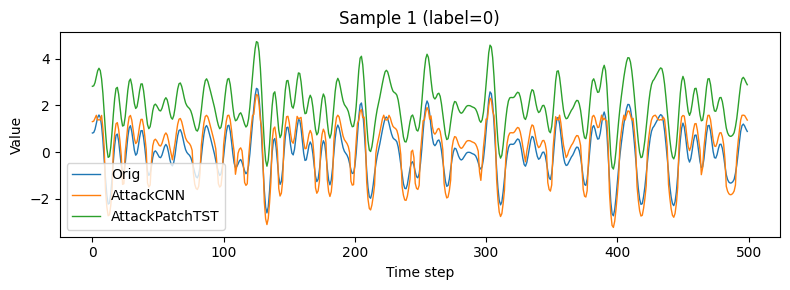

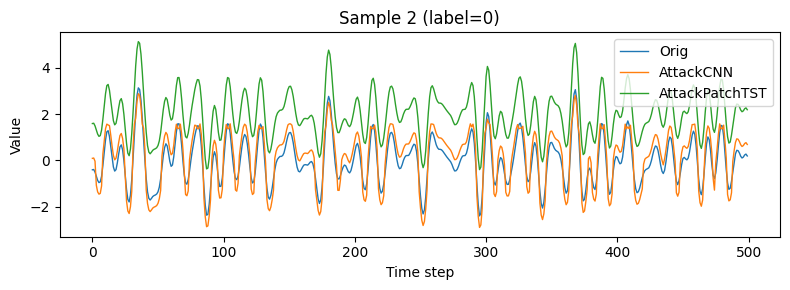

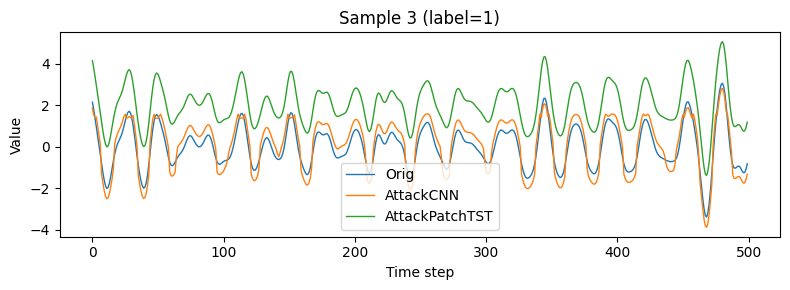

In [94]:
N_EXAMPLES = 3
FILTER = [1,2]
MBA_ATTACKS = [[mba_LSTM, mba_resCNN, mba_PatchTST][i] for i in FILTER]

# выбираем batch-и, вытаскиваем по одному примеру
chosen = []
for xb, yb in test_dl:
    for i in range(xb.size(0)):
        chosen.append((xb[i], yb[i]))
    if len(chosen) >= 50:       # достаточно выборки для случайного выбора
        break

examples = random.sample(chosen, N_EXAMPLES)

for sample_idx, (x_orig, y_lbl) in enumerate(examples, 1):
    x_orig = x_orig.to(device).unsqueeze(0)
    y_lbl_tensor = torch.tensor([y_lbl], device=device)  # создаем тензор для label
    x_np = x_orig.squeeze().cpu().numpy()
    x_adv_np_list = []
    
    for i, mba_attack in enumerate(MBA_ATTACKS):
        # Используем интерфейс ModelBasedAttack: mba_attack(model, x, y)
        # model здесь не используется внутри ModelBasedAttack, но нужен для интерфейса
        dummy_model = None  # или можно передать любую модель
        x_adv = mba_attack(dummy_model, x_orig, y_lbl_tensor)
        x_adv_np_list.append(x_adv.squeeze().cpu().numpy())

    plt.figure(figsize=(8, 3))
    plt.plot(x_np, label='Orig', linewidth=1)
    for i, x_adv_np in enumerate(x_adv_np_list):
        # Получаем имя класса внутреннего атакера
        attack_name = MBA_ATTACKS[i].attacker.__class__.__name__
        plt.plot(x_adv_np, label=f'{attack_name}', linewidth=1)
    plt.title(f'Sample {sample_idx} (label={int(y_lbl)})')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

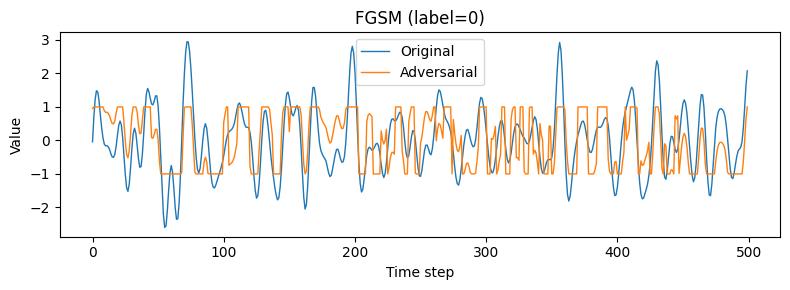

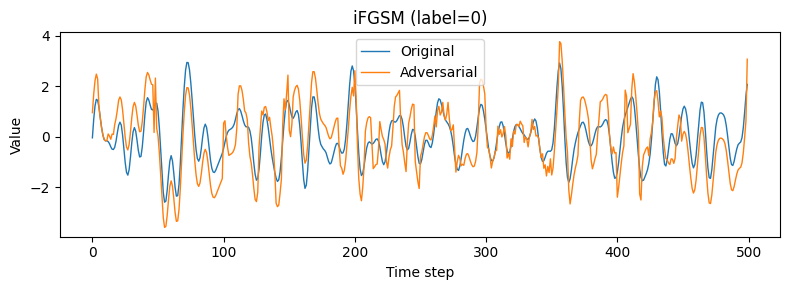

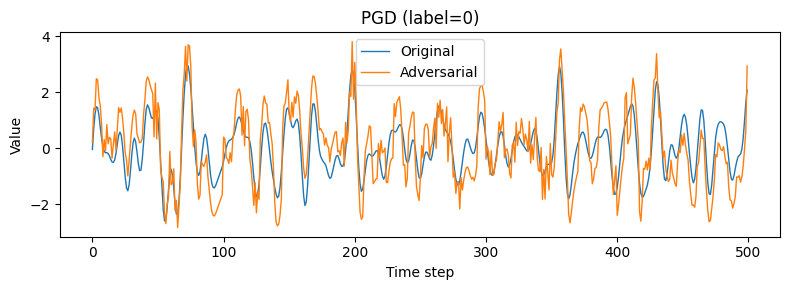

In [84]:
N_EXAMPLES = 3

EPS = 1
test_loader = test_dl
clf_model = clf_LSTM

attacks = { 'FGSM': fgsm_attack,
           'iFGSM': ifgsm_attack,
            'PGD': pgd_attack,
           }


idx = 7
for name, atk in attacks.items():
    fl_rate = -999
    ef_rate = -999
    # fl_rate = fooling_rate(model, test_loader, atk, device=device)
    # ef_rate = efficiency_rate(model, test_dl, atk, device=device)
    # acc = accuracy_after_attack(clf_model, test_dl, atk, device=device)
    # print(f'{name:<15} target accuracy after attack:  {acc:.3f}')


    x_orig = test_ds[idx][0].to(device)
    y_orig = test_ds[idx][1].to(device)

    x_orig = x_orig.unsqueeze(0)
    y_orig = y_orig.unsqueeze(0)

    x_adv = atk(clf_model, x_orig, y_orig)

    x_adv_np = x_adv[0].cpu().numpy()
    x_np = x_orig[0].cpu().numpy()

    # отдельный plot для каждой пары
    plt.figure(figsize=(8, 3))
    plt.plot(x_np,     label='Original', linewidth=1)
    plt.plot(x_adv_np, label=f'Adversarial', linewidth=1)
    plt.title(f'{name} (label={int(y_orig)})')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
plt.show()



